In [ ]:
from google.colab import auth
import ee
import geemap

# 1. Log in (You might not need to click this again if you already did)
auth.authenticate_user()

# 2. Initialize with your new ID
# REPLACE THE TEXT BELOW WITH YOUR ID (Keep the quotes!)
my_project_id = 'ist-research-2025'

try:
    ee.Initialize(project=my_project_id)
    print("SUCCESS: WE ARE LIVE.")
except Exception as e:
    print("Still failing. Error:", e)

# 3. If Success, Show the Map
if ee.data.getAlgorithms():
    Map = geemap.Map(center=[33.5194, 73.1709], zoom=10)
    collection = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2') \
        .select('tropospheric_NO2_column_number_density') \
        .filterDate('2025-11-01', '2025-11-22') \
        .mean()

    vis_params = {
        'min': 0,
        'max': 0.0002,
        'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
    }

    Map.addLayer(collection, vis_params, 'S5P NO2')
    display(Map)

SUCCESS: WE ARE LIVE.


Map(center=[33.5194, 73.1709], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

Requesting data from Google Earth Engine...
Data received. Processing graph...


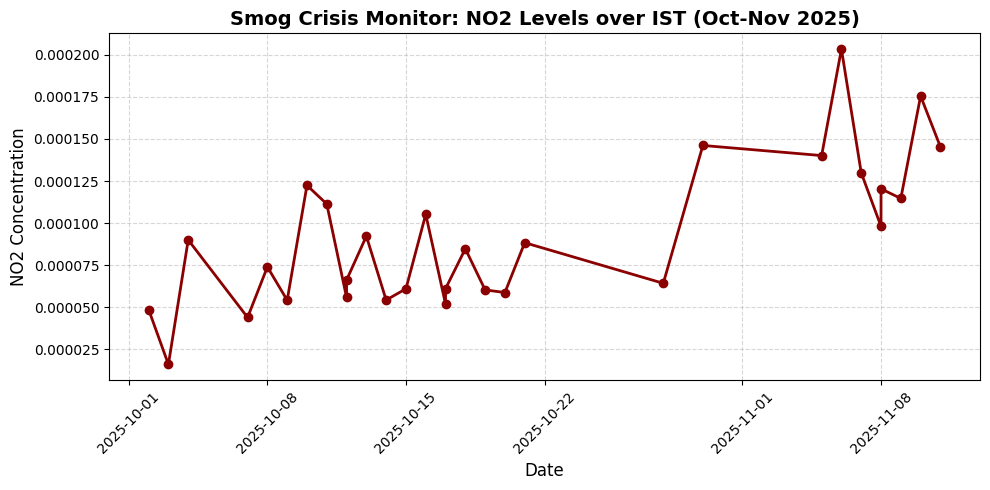

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ee

# 1. Define the Target: 5km around IST
ist_point = ee.Geometry.Point([73.1709, 33.5194])
roi = ist_point.buffer(5000)

# 2. Get Data for just the SMOG SEASON (Oct 1, 2025 - Nov 22, 2025)
# We shorten the date range to prevent the "5000 elements" crash
collection = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2') \
    .select('tropospheric_NO2_column_number_density') \
    .filterDate('2025-10-01', '2025-11-22') \
    .filterBounds(roi)

# 3. The Extraction Function
def get_pollution(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_val = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=1000,
        maxPixels=1e9
    ).get('tropospheric_NO2_column_number_density')
    return ee.Feature(None, {'date': date, 'NO2': mean_val})

print("Requesting data from Google Earth Engine...")

# 4. Execute with a safety limit
# We limit to the first 1000 images just in case, to stop the crash
pollution_data = collection.limit(1000).map(get_pollution).getInfo()

print("Data received. Processing graph...")

# 5. Clean and Plot
df = pd.DataFrame([x['properties'] for x in pollution_data['features']])

# Check if data is empty (clouds might have blocked everything)
if df.empty:
    print("Warning: No clear data found for this period (Too many clouds?).")
else:
    df['NO2'] = df['NO2'].astype(float)
    df['date'] = pd.to_datetime(df['date'])
    df = df.dropna()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], df['NO2'], marker='o', linestyle='-', color='darkred', linewidth=2)
    plt.title('Smog Crisis Monitor: NO2 Levels over IST (Oct-Nov 2025)', fontsize=14, fontweight='bold')
    plt.ylabel('NO2 Concentration', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()